# Tracking Dataset Processing

This notebook can be used to load, evaluate, compare, refine and export hand-labeled tracking datasets 

*(Data must be annotated with the blender [**OmniTrax**](https://github.com/FabianPlum/OmniTrax) addon or [**blenderMotionExport**](https://github.com/FabianPlum/blenderMotionExport) or follow the convention of individual CSV files per tracked animal with explicit frame numbers)*

First, let's load some packages and a few essential import / export functions from **Antrax_base.py** 

In [1]:
import numpy as np
import cv2
import csv
import os
import math
import time
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# now for the file management fucntions
from Antrax_base import import_tracks, display_video, get_exact_frame, extractPatches, display_patches, sortByDistance

To get more information on how each function works, you can simply type it out followed by a question mark to display its docstring below:

In [2]:
# Exp: Show the docstring of "import_tracks" by uncommenting the next line
#import_tracks?

Now specify the **location** of all **export folders** of tracks you wish to analyse. Simply add the folder path to the **export_paths** array and the location of the annotated video file.

In [3]:
export_paths = ["C:/export/ant_record_session2022-11-04_colour_adjusted_cropped_8fps"]
video = "D:/FilmAnts/recordings/2022-11-04/2022-11-04_colour_adjusted_cropped_8fps.mp4"

# enter the number of annotated frames:
tracked_frames = 30630

# now we can load the captured video file and display it
cap = cv2.VideoCapture(video)

# check the number of frames of the imported video file
numFramesMax = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("The imported clip:", video, "has a total of",numFramesMax ,"frames.\n")

# now let's load all tracks listed in the export_paths
tracks = []
for folder in export_paths:
    # You can export all tracks into a single .csv file by setting "export=True"
    tracks.append(import_tracks(folder, numFramesMax, export=True))
    
    # The following function is used to display the tracks you imported.
    # You can press "q" while hovering over the displayed video to exit.
    print("\nDisplaying tracks loaded from:", folder)
    display_video(cap, tracks[-1], show=(0, tracked_frames), scale=0.3)

The imported clip: D:/FilmAnts/recordings/2022-11-04/2022-11-04_colour_adjusted_cropped_8fps.mp4 has a total of 31126 frames.

importing tracks...
imported 2022-11-04_colour_adjusted_cropped_8fps_track_0.csv  with 371 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1.csv  with 178 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_10.csv  with 1476 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1000.csv  with 52 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1001.csv  with 70 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1002.csv  with 259 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1004.csv  with 271 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1005.csv  with 639 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1006.csv  with 379 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1007.csv  with 850 points.
imported 2022-11-04_colour_adjusted_croppe

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1130.csv  with 530 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1131.csv  with 175 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1132.csv  with 250 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1134.csv  with 484 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1135.csv  with 479 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_114.csv  with 115 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1140.csv  with 162 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1141.csv  with 992 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1142.csv  with 866 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1143.csv  with 546 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1147.csv  with 423 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1148.csv  with 70 points.
imported 2022-11-0

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1276.csv  with 319 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1277.csv  with 259 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1279.csv  with 317 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_128.csv  with 280 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1280.csv  with 54 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1282.csv  with 140 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1285.csv  with 262 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1286.csv  with 940 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1287.csv  with 108 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1288.csv  with 1900 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1289.csv  with 119 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1290.csv  with 586 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1399.csv  with 301 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_14.csv  with 859 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_140.csv  with 89 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1401.csv  with 725 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1403.csv  with 427 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1404.csv  with 407 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1405.csv  with 127 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_141.csv  with 145 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1410.csv  with 464 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1411.csv  with 341 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1412.csv  with 496 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1413.csv  with 616 points.
imported 2022-11-04_c

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1517.csv  with 174 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1518.csv  with 271 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1519.csv  with 762 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_152.csv  with 59 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1520.csv  with 215 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1521.csv  with 189 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1522.csv  with 231 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1524.csv  with 359 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1525.csv  with 67 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1526.csv  with 173 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1527.csv  with 112 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1528.csv  with 689 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_164.csv  with 191 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1640.csv  with 223 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1641.csv  with 237 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1642.csv  with 255 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1643.csv  with 243 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1645.csv  with 562 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1646.csv  with 519 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1647.csv  with 443 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1648.csv  with 465 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1649.csv  with 318 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_165.csv  with 530 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1650.csv  with 91 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_175.csv  with 152 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1750.csv  with 298 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1753.csv  with 163 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1756.csv  with 318 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1757.csv  with 122 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1759.csv  with 135 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_176.csv  with 286 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1760.csv  with 608 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1761.csv  with 89 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1762.csv  with 504 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1763.csv  with 245 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1765.csv  with 434 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1878.csv  with 294 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1879.csv  with 240 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_188.csv  with 59 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1880.csv  with 267 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1881.csv  with 579 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1882.csv  with 201 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1884.csv  with 203 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1885.csv  with 1593 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1889.csv  with 343 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_189.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1892.csv  with 596 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1893.csv  with 318 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_1996.csv  with 247 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1997.csv  with 589 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1998.csv  with 164 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_1999.csv  with 260 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2.csv  with 103 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_20.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2000.csv  with 348 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2003.csv  with 321 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2004.csv  with 680 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2005.csv  with 223 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2006.csv  with 186 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2008.csv  with 130 points.
imported 2022-11-04_co

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2128.csv  with 322 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2129.csv  with 114 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2130.csv  with 457 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2131.csv  with 338 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2132.csv  with 281 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2133.csv  with 247 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2134.csv  with 278 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2135.csv  with 771 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2136.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2137.csv  with 74 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2138.csv  with 141 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2140.csv  with 212 points.
imported 2022-11-0

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2250.csv  with 296 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2251.csv  with 229 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2252.csv  with 326 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2253.csv  with 392 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2254.csv  with 531 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2255.csv  with 553 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2256.csv  with 2206 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2257.csv  with 519 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2258.csv  with 130 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_226.csv  with 110 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2260.csv  with 351 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2264.csv  with 2127 points.
imported 2022-1

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2379.csv  with 61 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_238.csv  with 112 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2380.csv  with 259 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2381.csv  with 295 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2382.csv  with 371 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2383.csv  with 260 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2386.csv  with 533 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2387.csv  with 241 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_239.csv  with 1390 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2390.csv  with 480 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2391.csv  with 473 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2392.csv  with 495 points.
imported 2022-11-0

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2507.csv  with 273 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2508.csv  with 51 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2509.csv  with 252 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_251.csv  with 522 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2510.csv  with 621 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2511.csv  with 1025 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2512.csv  with 285 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2513.csv  with 286 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2514.csv  with 1670 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2515.csv  with 55 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2516.csv  with 129 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2517.csv  with 140 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2631.csv  with 787 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2632.csv  with 656 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2633.csv  with 64 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2634.csv  with 377 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2635.csv  with 550 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2636.csv  with 279 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2637.csv  with 233 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2638.csv  with 55 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2639.csv  with 197 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2640.csv  with 64 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2642.csv  with 62 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2643.csv  with 176 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2754.csv  with 445 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2755.csv  with 485 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2756.csv  with 302 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2757.csv  with 177 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2758.csv  with 129 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2759.csv  with 83 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_276.csv  with 1241 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2760.csv  with 97 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2761.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2762.csv  with 100 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2763.csv  with 527 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2764.csv  with 231 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2869.csv  with 130 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_287.csv  with 220 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2870.csv  with 171 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2871.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2872.csv  with 198 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2873.csv  with 175 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2874.csv  with 2611 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2876.csv  with 361 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2877.csv  with 745 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2879.csv  with 721 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_288.csv  with 88 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2880.csv  with 58 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_2986.csv  with 69 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_299.csv  with 323 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2993.csv  with 676 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2994.csv  with 401 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2995.csv  with 537 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2996.csv  with 195 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2997.csv  with 231 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_2998.csv  with 77 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3.csv  with 205 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_30.csv  with 274 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3000.csv  with 65 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3001.csv  with 80 points.
imported 2022-11-04_colour

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3098.csv  with 91 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3099.csv  with 98 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_31.csv  with 138 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_310.csv  with 416 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3101.csv  with 72 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3102.csv  with 66 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3103.csv  with 65 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3104.csv  with 82 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3105.csv  with 240 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3107.csv  with 112 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3109.csv  with 129 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_311.csv  with 904 points.
imported 2022-11-04_colour

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3204.csv  with 229 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3205.csv  with 1453 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3206.csv  with 170 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3207.csv  with 96 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3208.csv  with 328 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3209.csv  with 105 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_321.csv  with 70 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3210.csv  with 355 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3211.csv  with 706 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3212.csv  with 54 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3214.csv  with 299 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3215.csv  with 562 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3321.csv  with 344 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3322.csv  with 808 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3323.csv  with 319 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3324.csv  with 378 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3325.csv  with 2532 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3326.csv  with 806 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3327.csv  with 251 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3329.csv  with 62 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_333.csv  with 64 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3330.csv  with 138 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3331.csv  with 61 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3332.csv  with 108 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3441.csv  with 281 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3442.csv  with 564 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3443.csv  with 88 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3444.csv  with 85 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3446.csv  with 59 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3447.csv  with 80 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3448.csv  with 73 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3449.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_345.csv  with 65 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3450.csv  with 349 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3451.csv  with 212 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3452.csv  with 411 points.
imported 2022-11-04_colo

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3558.csv  with 106 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3559.csv  with 1452 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_356.csv  with 352 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3560.csv  with 308 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3561.csv  with 54 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3562.csv  with 535 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3563.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3564.csv  with 761 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3565.csv  with 185 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3567.csv  with 374 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3568.csv  with 367 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3569.csv  with 435 points.
imported 2022-11-0

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3678.csv  with 1239 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3679.csv  with 390 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_368.csv  with 379 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3680.csv  with 387 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3681.csv  with 518 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3686.csv  with 53 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3687.csv  with 105 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_369.csv  with 935 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3692.csv  with 55 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3693.csv  with 53 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3694.csv  with 52 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3695.csv  with 273 points.
imported 2022-11-04_c

imported 2022-11-04_colour_adjusted_cropped_8fps_track_379.csv  with 1040 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3790.csv  with 474 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3791.csv  with 120 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3792.csv  with 124 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3794.csv  with 119 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3795.csv  with 115 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3796.csv  with 457 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3797.csv  with 332 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3798.csv  with 119 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_380.csv  with 483 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3800.csv  with 145 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3801.csv  with 122 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_3909.csv  with 105 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_391.csv  with 566 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3910.csv  with 383 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3912.csv  with 479 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3913.csv  with 612 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3914.csv  with 1367 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3915.csv  with 224 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3916.csv  with 102 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3917.csv  with 404 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3919.csv  with 372 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3922.csv  with 223 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_3923.csv  with 502 points.
imported 2022-11

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4029.csv  with 194 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_403.csv  with 108 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4030.csv  with 259 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4031.csv  with 253 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4032.csv  with 377 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4034.csv  with 2440 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4035.csv  with 589 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4036.csv  with 126 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4037.csv  with 265 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4038.csv  with 472 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_404.csv  with 124 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4041.csv  with 526 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4147.csv  with 311 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4149.csv  with 868 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_415.csv  with 53 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4150.csv  with 133 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4151.csv  with 56 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4152.csv  with 843 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4153.csv  with 668 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4155.csv  with 85 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4156.csv  with 71 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4157.csv  with 1669 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4158.csv  with 410 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4159.csv  with 291 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4272.csv  with 397 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4273.csv  with 196 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4274.csv  with 148 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4278.csv  with 1056 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4279.csv  with 154 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4280.csv  with 158 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4281.csv  with 177 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4282.csv  with 109 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4283.csv  with 531 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4284.csv  with 71 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4285.csv  with 52 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_429.csv  with 64 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4419.csv  with 133 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_442.csv  with 330 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4420.csv  with 234 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4424.csv  with 457 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4428.csv  with 170 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4429.csv  with 216 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4430.csv  with 488 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4431.csv  with 212 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4432.csv  with 301 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4434.csv  with 326 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4436.csv  with 114 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4437.csv  with 417 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4568.csv  with 1465 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4569.csv  with 950 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4570.csv  with 176 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4571.csv  with 791 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4572.csv  with 279 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4573.csv  with 1340 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4574.csv  with 323 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4575.csv  with 494 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4576.csv  with 430 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4577.csv  with 1249 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_458.csv  with 143 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4580.csv  with 134 points.
imported 2022-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4692.csv  with 57 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4693.csv  with 69 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4694.csv  with 87 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4696.csv  with 1441 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4697.csv  with 438 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4698.csv  with 132 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4699.csv  with 320 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_47.csv  with 859 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_470.csv  with 51 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4701.csv  with 319 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4702.csv  with 321 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4703.csv  with 57 points.
imported 2022-11-04_col

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4820.csv  with 647 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4821.csv  with 146 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4822.csv  with 224 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4823.csv  with 667 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4824.csv  with 407 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4826.csv  with 334 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4827.csv  with 285 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4828.csv  with 275 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4829.csv  with 328 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4830.csv  with 113 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4832.csv  with 103 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4837.csv  with 135 points.
imported 2022-11

imported 2022-11-04_colour_adjusted_cropped_8fps_track_4945.csv  with 668 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4948.csv  with 249 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4949.csv  with 206 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_495.csv  with 103 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4951.csv  with 106 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4952.csv  with 122 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4954.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4955.csv  with 94 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4956.csv  with 57 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4957.csv  with 218 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4958.csv  with 217 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_4959.csv  with 946 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_507.csv  with 512 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5072.csv  with 253 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5073.csv  with 318 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5076.csv  with 59 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5077.csv  with 598 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_508.csv  with 820 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5080.csv  with 642 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5081.csv  with 159 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5082.csv  with 290 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5083.csv  with 549 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5084.csv  with 192 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5085.csv  with 66 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_5214.csv  with 93 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5215.csv  with 73 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5216.csv  with 114 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5217.csv  with 545 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5218.csv  with 195 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5219.csv  with 277 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_522.csv  with 1079 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5220.csv  with 354 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5221.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5222.csv  with 73 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5223.csv  with 101 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5224.csv  with 70 points.
imported 2022-11-04_c

imported 2022-11-04_colour_adjusted_cropped_8fps_track_5337.csv  with 1198 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5338.csv  with 241 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5339.csv  with 364 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_534.csv  with 576 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5340.csv  with 531 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5341.csv  with 534 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5342.csv  with 283 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5343.csv  with 73 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5344.csv  with 953 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5345.csv  with 1240 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5347.csv  with 338 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5348.csv  with 825 points.
imported 2022-11

imported 2022-11-04_colour_adjusted_cropped_8fps_track_548.csv  with 388 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5481.csv  with 194 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5482.csv  with 51 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5483.csv  with 50 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5484.csv  with 124 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5485.csv  with 212 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5486.csv  with 97 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5488.csv  with 94 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5489.csv  with 216 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_549.csv  with 83 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5490.csv  with 355 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5491.csv  with 234 points.
imported 2022-11-04_col

imported 2022-11-04_colour_adjusted_cropped_8fps_track_5621.csv  with 93 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5622.csv  with 152 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5623.csv  with 274 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5624.csv  with 320 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5625.csv  with 493 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5629.csv  with 228 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_563.csv  with 714 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5635.csv  with 557 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5636.csv  with 147 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_564.csv  with 567 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5641.csv  with 628 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5645.csv  with 629 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_5774.csv  with 929 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5775.csv  with 212 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5776.csv  with 324 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5778.csv  with 542 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_578.csv  with 144 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5780.csv  with 718 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5782.csv  with 106 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5783.csv  with 196 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5784.csv  with 146 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5785.csv  with 301 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5786.csv  with 446 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5787.csv  with 113 points.
imported 2022-11-

imported 2022-11-04_colour_adjusted_cropped_8fps_track_5907.csv  with 1015 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5908.csv  with 468 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5909.csv  with 79 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_591.csv  with 416 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5910.csv  with 95 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5911.csv  with 157 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5913.csv  with 85 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5914.csv  with 115 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5915.csv  with 108 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5916.csv  with 1659 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5918.csv  with 68 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_5919.csv  with 295 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6017.csv  with 662 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6018.csv  with 233 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6019.csv  with 578 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6020.csv  with 796 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6021.csv  with 788 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6022.csv  with 50 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6023.csv  with 489 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6024.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6028.csv  with 446 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6029.csv  with 731 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_603.csv  with 117 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6030.csv  with 127 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6157.csv  with 371 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6158.csv  with 79 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6159.csv  with 119 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6160.csv  with 273 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6162.csv  with 516 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6163.csv  with 274 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6164.csv  with 115 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6167.csv  with 527 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6168.csv  with 177 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6169.csv  with 171 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6170.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6171.csv  with 227 points.
imported 2022-11-0

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6279.csv  with 101 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6281.csv  with 53 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6283.csv  with 299 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6288.csv  with 67 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_629.csv  with 75 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6290.csv  with 83 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6291.csv  with 99 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6292.csv  with 67 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6294.csv  with 50 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6299.csv  with 377 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_63.csv  with 389 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6300.csv  with 376 points.
imported 2022-11-04_colour

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6428.csv  with 73 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_643.csv  with 51 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6434.csv  with 190 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6435.csv  with 644 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6436.csv  with 417 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6438.csv  with 235 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6439.csv  with 656 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_644.csv  with 99 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6441.csv  with 181 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6442.csv  with 483 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6445.csv  with 93 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6447.csv  with 502 points.
imported 2022-11-04_co

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6569.csv  with 92 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6570.csv  with 146 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6571.csv  with 143 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6572.csv  with 145 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6573.csv  with 56 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6574.csv  with 142 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6576.csv  with 219 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6577.csv  with 246 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6578.csv  with 76 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6579.csv  with 242 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_658.csv  with 327 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6582.csv  with 185 points.
imported 2022-11-04_

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6689.csv  with 265 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_669.csv  with 687 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6691.csv  with 664 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6693.csv  with 106 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6694.csv  with 667 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6695.csv  with 255 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6697.csv  with 113 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6699.csv  with 650 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_670.csv  with 460 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6700.csv  with 303 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6701.csv  with 77 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6702.csv  with 262 points.
imported 2022-11-04

imported 2022-11-04_colour_adjusted_cropped_8fps_track_6832.csv  with 97 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6833.csv  with 93 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6834.csv  with 90 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6835.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6836.csv  with 88 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6837.csv  with 85 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6838.csv  with 80 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6839.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_684.csv  with 60 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6840.csv  with 78 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_6844.csv  with 58 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_685.csv  with 783 points.
imported 2022-11-04_colour_ad

imported 2022-11-04_colour_adjusted_cropped_8fps_track_786.csv  with 107 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_788.csv  with 407 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_789.csv  with 105 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_791.csv  with 504 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_798.csv  with 77 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_799.csv  with 77 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_8.csv  with 649 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_800.csv  with 499 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_801.csv  with 250 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_802.csv  with 1356 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_803.csv  with 807 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_804.csv  with 378 points.
imported 2022-11-04_colour_adju

imported 2022-11-04_colour_adjusted_cropped_8fps_track_918.csv  with 79 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_919.csv  with 64 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_92.csv  with 1557 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_920.csv  with 60 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_921.csv  with 492 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_922.csv  with 901 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_926.csv  with 105 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_928.csv  with 512 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_929.csv  with 375 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_93.csv  with 1014 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_930.csv  with 523 points.
imported 2022-11-04_colour_adjusted_cropped_8fps_track_931.csv  with 815 points.
imported 2022-11-04_colour_adju

Next, we'll plot the imported trajectories from each subfolder.

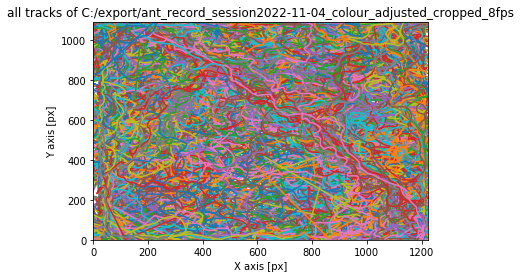

In [10]:
# get the resolution of the video file to automatically adjust the axis limits of the plot
resolution = [int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))]

def plot_tracks(tracks, title=""):
    # replace all zeros with None before plotting
    tracks = tracks.astype(float)
    tracks[tracks == 0] = None

    for track in range(int((tracks.shape[-1] - 1) / 2)):
        plt.plot(tracks[:tracked_frames,int(track*2 + 1)],tracks[:tracked_frames,int(track*2 + 2)])

        plt.title(title)    
        plt.xlabel("X axis [px]")   
        plt.ylabel("Y axis [px]")
        plt.xlim(0,resolution[0])
        plt.ylim(0,resolution[1])
    
    plt.savefig(video.split(".")[0] + "_all_tracks.svg")
    plt.show()
    
# plot all tracks    
for count, annotator in enumerate(tracks):
    num_tracks = int((annotator.shape[-1] - 1)/2)  
    plot_tracks(tracks=annotator,title="all tracks of " + export_paths[count])

Now we'll match the **tracks** of **all annotators** based on their **proximity**. We'll iterate through all tracks of the first annotator and compute a similirity score based on the distance of each tracked instance, ignoring zeros.

In [ ]:
def get_similarity(track_1, track_2, matching_threshold=50):
    # here we use the pixel distance as a metric of similarity
    # the lower the pixel distance, thus similarity value, the higher the liklihood of two track belonging to the same ID
    combined_distance = []
    track_1 = track_1.astype(float)
    track_2 = track_2.astype(float)
    for frame, coords in enumerate(track_1):
        if not np.array_equal(track_1[frame],[0,0]) and not np.array_equal(track_2[frame],[0,0]):
            combined_distance.append(np.sqrt(np.power(track_1[frame,0] - track_2[frame,0],2) +
                                             np.power(track_1[frame,1] - track_2[frame,1],2)))
            
    # now compute the similarity as the mean distance between the two tracks
    if combined_distance:
        similarity = np.round(np.mean(combined_distance), decimals=3)
    else:
        similarity = matching_threshold
    return similarity


def match_tracks(tracks_a, tracks_b):
    num_tracks_a = int((tracks_a.shape[1] - 1)/2)
    num_tracks_b = int((tracks_b.shape[1] - 1)/2)
    similarities = np.empty([num_tracks_a, num_tracks_b], dtype=float)
    print("Similarity grid shape:", similarities.shape, "\n")
    print("Computing similarities...")

    # compare all tracks of 2 annotators at a time and match them based on their mean euclidean distance
    for a in range(similarities.shape[0]):
        for b in range (similarities.shape[1]):
            similarities[a,b] = get_similarity(track_1=tracks_a[:tracked_frames,a*2 + 1:a*2 + 3],
                                               track_2=tracks_b[:tracked_frames,b*2 + 1:b*2 + 3],
                                               matching_threshold = matching_threshold)

    # record the indices of all likely matches and unmatched tracks
    matched = []
    unmatched_a = []
    unmatched_b = np.arange(num_tracks_b)

    for track_a, track_a_similarities in enumerate(similarities):
        sim_max = np.argmin(track_a_similarities[np.nonzero(track_a_similarities)])
        if track_a_similarities[sim_max] < matching_threshold:
            matched.append([track_a,sim_max])
            unmatched_b[sim_max] = 0
            print("Track", track_a, "most likely corresponds to Track", sim_max,
                  "with a mean euclidean distance [px] of", track_a_similarities[sim_max])
        else:
            unmatched_a.append(track_a)
            print("Track", track_a, "has no likely match.")

    # show list of matched tracks        
    print("\nmatched:\n",matched,"\n")

    if len(unmatched_a) > 0:
        print("Unmatched tracks of",export_paths[0],": \n",unmatched_a,"\n")
    else:
        print("All tracks of",export_paths[0], "have been matched!\n")

    # create the final list of unmatched_b tracks
    unmatched_b = unmatched_b[unmatched_b != 0]
    if len(unmatched_b) > 0:
        print("Unmatched tracks of",export_paths[1],": \n",unmatched_b,"\n")
    else:
        print("All tracks of",export_paths[1], "have been matched!\n")

    return matched, unmatched_a, unmatched_b


def generate_ground_truth(tracks_a, tracks_b, matches, unmatched_a, unmatched_b, num_frames, 
                          iteration=0, ignore_unmatched=False):
    # create array of the size of (num_frames x (frame + all_tracks(x,y)))
    ground_truth = np.zeros([num_frames, 1 + 2 * (len(matches) + len(unmatched_a) + len(unmatched_b))])
    
    # add frame numers to the first column
    frames = np.arange(1,num_frames + 1)
    
    ground_truth[:,0] = frames
    
    if iteration == 0:
        print("Initial combination of tracks. All are weighted equally")
    else: 
        print("Iteration:", iteration)
        print("Additional tracks contribute with 1/"+ str(iteration + 2),"weight.\n")
    
    # now compute the weighted average for every matching track
    for count, match in enumerate(matches):
        for frame in range(ground_truth.shape[0]):
            pos_a_x, pos_a_y = tracks_a[frame , 2 * match[0] + 1 : 2 * match[0] + 3]
            pos_b_x, pos_b_y = tracks_b[frame , 2 * match[1] + 1 : 2 * match[1] + 3]
            
            pos_sum_x = pos_a_x * (1 + iteration) + pos_b_x
            pos_sum_y = pos_a_y * (1 + iteration) + pos_b_y
            
            if pos_a_x != 0 and pos_b_x != 0:
                ground_truth[frame,count * 2 + 1] = pos_sum_x / (2 + iteration)
            else:
                # only compute the average if both values are non-zero
                # If one value is zero, only the other should contribute to the track
                ground_truth[frame,count * 2 + 1] = pos_sum_x
                
            # repeat for the y-axis
            
            if pos_a_y != 0 and pos_b_y != 0:
                ground_truth[frame,count * 2 + 2] = pos_sum_y / (2 + iteration)
            else:
                # only compute the average if both values are non-zero
                # If one value is zero, only the other should contribute to the track
                ground_truth[frame,count * 2 + 2] = pos_sum_y
                
    # add the remaining unmatched_a tracks
    if len(unmatched_a) > 0:
        for count, unmatched in enumerate(unmatched_a):
            ground_truth[:,(count + len(matches)) * 2 + 1: (count + len(matches)) * 2 + 3] = tracks_a[
                :tracked_frames,unmatched * 2 + 1 : unmatched * 2 + 3]
    
    # add the remaining unmatched_b tracks
    if len(unmatched_b) > 0:
        for count, unmatched in enumerate(unmatched_b):
            ground_truth[:,(count + len(unmatched_a) + len(matches)) * 2 + 1: 
                         (count + len(unmatched_a) + len(matches)) * 2 + 3] = tracks_b[
                :tracked_frames,unmatched * 2 + 1 : unmatched * 2 + 3]
    
    return ground_truth

After computing **likely matching tracks** we can now combine them into **ground truth tracks**, which are a weighted average of all matching tracks. **Unmatched tracks** are added without modification. Then, we iteratively compare the current ground truth to further annotators.

In [ ]:
# adjust the matching threshold according to the track quality and resolution of the tracked footage
matching_threshold = 50

# compute a grid of similarities between all tracks

matched, unmatched_a, unmatched_b = match_tracks(tracks_a = tracks[0], tracks_b = tracks[1])

In [ ]:
gt = generate_ground_truth(tracks_a=tracks[0], tracks_b=tracks[1], matches=matched, unmatched_a=unmatched_a, 
                      unmatched_b=unmatched_b, num_frames=tracked_frames, iteration=0)

print("Generated a total of",int((gt.shape[-1] - 1) / 2),"ground truth tracks.")

display_video(cap, gt, show=(0, tracked_frames - 2), scale=0.3)

# plot resulting ground truth tracks
plot_tracks(tracks=gt, title="all ground truth tracks")

The generated **ground truth tracks** can now be exported.

In [ ]:
def export_tracks(tracks,path="ground_truth"):
    tracks = tracks.astype(int)
    np.savetxt(path + ".csv", tracks, delimiter=",")
    
    print("Exported tracks successfully to", path + ".csv")
    
export_tracks(tracks=gt, path="ground_truth_" + video.split(".")[0])

We can also **import** existing ground truth files for evaluation or to add further annotators. When adding additional annotators, make sure to correctly set the iteration to weigh the influence of further tracks correctly.

In [6]:
def import_ground_truth(path):
    tracks = np.loadtxt(path, delimiter=",")
    tracks = tracks.astype(int)
    
    print("Imported tracks successfully from", path)
    
    return tracks

new_gt = import_ground_truth(path="C:/export/ant_record_session2022-11-04_colour_adjusted_cropped_8fps_all_tracks.csv")

Imported tracks successfully from C:/export/ant_record_session2022-11-04_colour_adjusted_cropped_8fps_all_tracks.csv


In [7]:
def get_derivative(tracks, time_step=1/30):
    tracks_der = np.zeros([tracks.shape[0],int((tracks.shape[1] - 1)/2)])
    # convert tracks to float array
    tracks_der = tracks_der.astype(float)
    
    num_tracks = int((tracks.shape[1] - 1)/2)  
    num_timeSteps = tracks.shape[0]
    
    print("Computing derivative for", num_tracks, "tracks...")
    for track in range(num_tracks):
        track_der = []
        for t in range(num_timeSteps - 1):
            if tracks[t + 1,track * 2 + 1] != 0 and tracks[t + 1,track * 2 + 2] != 0:   
                tracks_der[t,track] = np.sqrt((tracks[t + 1,track * 2 + 1] - tracks[t,track * 2 + 1])**2 + 
                                              (tracks[t + 1,track * 2 + 2] - tracks[t,track * 2 + 2])**2) / time_step
            
    return tracks_der

def apply_moving_average(tracks, samples=3, padding_mode='valid'):
    tracks_ma = np.copy(tracks)
    num_tracks = int((tracks.shape[1] - 1)/2)  
    num_timeSteps = tracks.shape[0]

    print("Applying moving average of size", samples, "to", num_tracks, "tracks...")
    for t in range(num_tracks):
        # apply smoothing only to areas where tracked subject is in view
        # therefore, all zero entries must be ignored
        track_temp_x = tracks[:,t * 2 + 1]
        track_temp_y = tracks[:,t * 2 + 2]
        
        nonzeroind = np.nonzero(track_temp_x)[0]
        
        track_x = np.convolve(track_temp_x[nonzeroind[0]:nonzeroind[-1]-samples], np.ones(samples)/samples, mode=padding_mode)
        track_y = np.convolve(track_temp_y[nonzeroind[0]:nonzeroind[-1]-samples], np.ones(samples)/samples, mode=padding_mode)
        
        tracks_ma[nonzeroind[0] + math.floor(samples/2):nonzeroind[-1] - math.ceil(samples/2) - samples + 1, t * 2 + 1] = track_x
        tracks_ma[nonzeroind[0] + math.floor(samples/2):nonzeroind[-1] - math.ceil(samples/2) - samples + 1, t * 2 + 2] = track_y    
        
    # add back zeros
    tracks_ma = tracks_ma.astype(int)
    return tracks_ma

Applying moving average of size 9 to 4932 tracks...
Computing derivative for 4932 tracks...


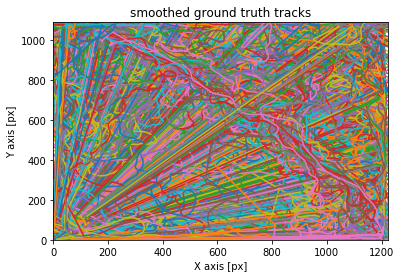

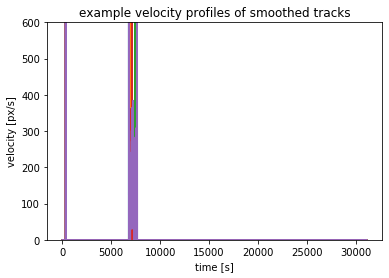

In [8]:
tracks_smoothed = apply_moving_average(new_gt, samples=9)
tracks_velocity = get_derivative(tracks_smoothed)

# plot smoothed ground truth tracks
plot_tracks(tracks=tracks_smoothed, title="smoothed ground truth tracks")

# plot velocity profile of example ground truth tracks
plt.plot(tracks_velocity[:,5:10])
plt.title("example velocity profiles of smoothed tracks")
plt.xlabel("time [s]")
plt.ylabel("velocity [px/s]")
plt.ylim(0,600)
plt.show()

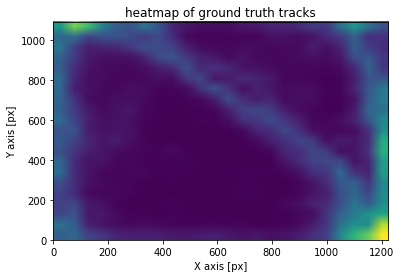

In [11]:
# plot heatmap of ground truth tracks
# first, combine all traccks into an array of X,Y coords
tracks_compressed = np.array([], dtype=np.int64).reshape(0,2)
for track in range(int((new_gt.shape[1] - 1)/2)):
    tracks_compressed = np.vstack((tracks_compressed,new_gt[:,track * 2 + 1 : track * 2 + 3]))
    
# now remove all zero entries from the array to prevent the 0 bin from over saturating the plot
tracks_compressed = tracks_compressed[~np.all(tracks_compressed == 0, axis=1)]
    
heatmap, xedges, yedges = np.histogram2d(tracks_compressed[:,0], tracks_compressed[:,1], 
                                         bins=(int(resolution[0]/50),int(resolution[1]/50)),
                                         range=[[0,resolution[0]],[0,resolution[1]]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

from matplotlib.image import NonUniformImage

fig, ax = plt.subplots()

im = NonUniformImage(ax, interpolation='bilinear', extent=extent)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, heatmap.T)
ax.images.append(im)

plt.xlabel("X axis [px]")   
plt.ylabel("Y axis [px]")
plt.xlim(0,resolution[0])
plt.ylim(0,resolution[1])
plt.title("heatmap of ground truth tracks")
plt.savefig(video.split(".")[0] + "_heatmap_of_ground_truth_tracks.svg")
plt.show()